<a href="https://colab.research.google.com/github/Ziyi-star/Bachelor-Project/blob/main/notebooks/Handlebar/03-Lstm__Handlebar_tensorflow_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For Vscode
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

import sys
sys.path.append('../../')   # Add parent directory to Python path
from utils.Plots import *

df = pd.read_csv('../../data/handlebar/Accelerometer_data_combined.csv')
# 0 for normal, 1 for abnormal
df['curb_scene'].value_counts()
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,NTP,Acc-X,Acc-Y,Acc-Z,Timestamp_unix,curb_activity,curb_scene,curb_height_down,curb_height_up,curb_type_down,curb_type_up,roughness
0,2024-07-24 10:26:01.863,1.417374,4.161118,8.762772,1.721817e+12,1.0,0.0,1.0,3.0,1.0,2.0,-1.0
1,2024-07-24 10:26:01.867,1.393433,4.161118,8.753204,1.721817e+12,1.0,0.0,1.0,3.0,1.0,2.0,-1.0
2,2024-07-24 10:26:01.872,1.407791,4.165909,8.762772,1.721817e+12,1.0,0.0,1.0,3.0,1.0,2.0,-1.0
3,2024-07-24 10:26:01.877,1.446091,4.170700,8.781937,1.721817e+12,1.0,0.0,1.0,3.0,1.0,2.0,-1.0
4,2024-07-24 10:26:01.884,1.417374,4.175491,8.753204,1.721817e+12,1.0,0.0,1.0,3.0,1.0,2.0,-1.0


In [1]:
# For Colab
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md


import os
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Project/data/Accelerometer_data_combined.csv')
# # 0 for normal, 1 for abnormal
df['curb_scene'].value_counts()
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

Mounted at /content/drive


,NTP,Acc-X,Acc-Y,Acc-Z,Timestamp_unix,curb_activity,curb_scene,curb_height_down,curb_height_up,curb_type_down,curb_type_up,roughness
0,2024-07-24 10:26:01.863,1.417374,4.161118,8.762772,1.721817e+12,1.0,0.0,1.0,3.0,1.0,2.0,-1.0
1,2024-07-24 10:26:01.867,1.393433,4.161118,8.753204,1.721817e+12,1.0,0.0,1.0,3.0,1.0,2.0,-1.0
2,2024-07-24 10:26:01.872,1.407791,4.165909,8.762772,1.721817e+12,1.0,0.0,1.0,3.0,1.0,2.0,-1.0
3,2024-07-24 10:26:01.877,1.446091,4.170700,8.781937,1.721817e+12,1.0,0.0,1.0,3.0,1.0,2.0,-1.0
4,2024-07-24 10:26:01.884,1.417374,4.175491,8.753204,1.721817e+12,1.0,0.0,1.0,3.0,1.0,2.0,-1.0


In [5]:
# I want time from 2024-07-24 11:03:00 to end to be test data and rest to be training data
df['NTP'] = pd.to_datetime(df['NTP'])
df_test = df[df['NTP'] > '2024-07-24 11:03:00']
df_train = df[df['NTP'] <= '2024-07-24 11:03:00']
df_train.shape, df_test.shape

((364816, 12), (101160, 12))

In [ ]:
# # Visualize the train,test data
# plot_accelerometer_data(df_train, 'Handlebar Accelerometer Data Train')
# plot_accelerometer_data(df_test, 'Handlebar Accelerometer Data Test')

In [6]:
#Select important feature from train and test data
df_train_filtered = df_train[['Acc-Z','curb_scene']]
df_test_filtered = df_test[['Acc-Z','curb_scene']]

In [7]:
# just the curb_scene = 0 in train data
df_train_filtered_normal = df_train_filtered[df_train_filtered['curb_scene'] == 0]
df_train_filtered_abnormal = df_train_filtered[df_train_filtered['curb_scene'] == 1]
df_train_filtered_normal.shape,df_train_filtered_abnormal.shape

((351158, 2), (13658, 2))

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(df_train_filtered_normal[['Acc-Z']])
df_train_filtered_normal['Acc-Z'] = scaler.transform(df_train_filtered_normal[['Acc-Z']])
df_train_filtered_abnormal['Acc-Z'] = scaler.transform(df_train_filtered_abnormal[['Acc-Z']])
df_train_filtered['Acc-Z'] = scaler.transform(df_train_filtered[['Acc-Z']])
df_test_filtered['Acc-Z'] = scaler.transform(df_test_filtered[['Acc-Z']])
#sort the data
df_train_filtered_normal.sort_index(inplace=True)
df_train_filtered_normal.min(),df_train_filtered_normal.max()

<ipython-input-8-70609ed7ec43>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_filtered_normal['Acc-Z'] = scaler.transform(df_train_filtered_normal[['Acc-Z']])
<ipython-input-8-70609ed7ec43>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_filtered_abnormal['Acc-Z'] = scaler.transform(df_train_filtered_abnormal[['Acc-Z']])
<ipython-input-8-70609ed7ec43>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

(Acc-Z        -30.456949
 curb_scene     0.000000
 dtype: float64,
 Acc-Z         17.104443
 curb_scene     0.000000
 dtype: float64)

In [9]:
def to_sequences(x, seq_size=1):
    x_values = []
    for i in range(len(x)-seq_size):
        #print(i)
        #sequence of values
        x_values.append(x.iloc[i:(i+seq_size)].values)
    return np.array(x_values)

In [10]:
seq_size= 100
trainX = to_sequences(df_train_filtered_normal['Acc-Z'],seq_size)
#testX= to_sequences(df_test_filtered['Acc-Z'], seq_size,)
trainX.shape


(351058, 100)

In [11]:
# Reshape the data to (num_samples, seq_len, n_features)
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
#testX = testX.reshape((testX.shape[0], testX.shape[1], 1))
trainX.shape
#testX.shape

(351058, 100, 1)

In [12]:
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.models import Model

model = Sequential()
# Encoder
model.add(Input(shape=(trainX.shape[1], trainX.shape[2])))
model.add(LSTM(64, activation='tanh', return_sequences=False))
#not Overfitting
model.add(Dropout(rate=0.1))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(64, activation='tanh', return_sequences=True))
model.add(Dropout(rate=0.1))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 64)             │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 100, 1)              │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# define early stopping to prevent overfit
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss",
                                               patience=10,
                                               mode="min",
                                               verbose=1,
                                               restore_best_weights=True)

In [16]:
# fit model
history = model.fit(
    trainX, trainX,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping],
    verbose=1)

Epoch 1/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - loss: 0.5550 - val_loss: 0.8736
Epoch 2/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - loss: 0.5549 - val_loss: 0.8736
Epoch 3/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - loss: 0.5549 - val_loss: 0.8736
Epoch 4/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - loss: 0.5549 - val_loss: 0.8736
Epoch 5/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - loss: 0.5549 - val_loss: 0.8735
Epoch 6/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - loss: 0.5549 - val_loss: 0.8735
Epoch 7/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - loss: 0.5549 - val_loss: 0.8734
Epoch 8/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - loss: 0.5548 - val_loss: 0.8733
Epoch 9/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - loss: 0.5548 - val_loss: 0.8732
Epoch 10/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - loss: 0.5544 - val_loss: 0.8718
Epoch 11/100
618/618 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - loss: 0.5539 - val_loss: 0.8715
Epoch 12/100
618/61

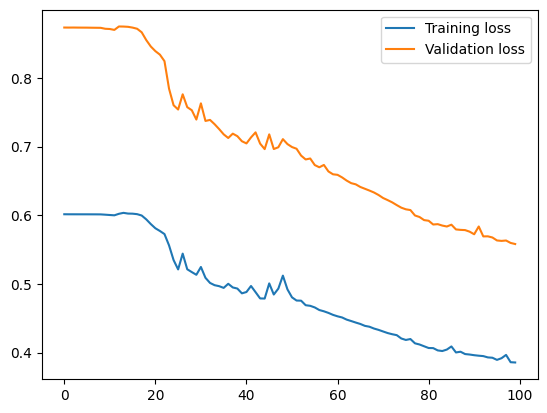

In [17]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

Epoch 1/100


ValueError: Cannot take the length of shape with unknown rank.